### Get the content of correct answers in the options ###

In [1]:
import pandas as pd
import numpy as np
import json


# training data

with open('dataset/MathQA/train.json') as f:
    data = json.loads(f.read())
    
train_df = pd.DataFrame(data)

print('training problems number: ', train_df['Problem'].count())
print(train_df.groupby(['category'])['Problem'].count())

train_df.head(5)

training problems number:  29837
category
gain            5120
general        13273
geometry        2117
other           1814
physics         7063
probability      450
Name: Problem, dtype: int64


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category
0,the banker ' s gain of a certain sum due 3 yea...,"""explanation : t = 3 years r = 10 % td = ( bg ...","a ) rs . 400 , b ) rs . 300 , c ) rs . 500 , d...",a,"divide(multiply(const_100, divide(multiply(36,...","multiply(n2,const_100)|multiply(n0,n1)|divide(...",gain
1,average age of students of an adult school is ...,"""explanation : let the original no . of studen...","a ) 1200 , b ) 120 , c ) 360 , d ) 240 , e ) n...",d,"multiply(divide(subtract(multiply(add(32, 4), ...","add(n2,n3)|multiply(n1,n2)|multiply(n1,#0)|sub...",general
2,sophia finished 2 / 3 of a book . she calculat...,let xx be the total number of pages in the boo...,"a ) 229 , b ) 270 , c ) 877 , d ) 266 , e ) 281",b,"divide(90, subtract(const_1, divide(2, 3)))","divide(n0,n1)|subtract(const_1,#0)|divide(n2,#1)",general
3,120 is what percent of 50 ?,"""50 * x = 120 - - > x = 2.4 - - > 2.4 expresse...","a ) 5 % , b ) 240 % , c ) 50 % , d ) 2 % , e )...",b,"multiply(divide(120, 50), const_100)","divide(n0,n1)|multiply(#0,const_100)|",gain
4,there are 10 girls and 20 boys in a classroom ...,"if girls is 10 and boys is 20 , then 10 / 20 ....","a ) 1 / 2 , b ) 1 / 3 , c ) 1 / 5 , d ) 10 / 3...",a,"divide(10, 20)","divide(n0,n1)",other


In [2]:
# remove the problems that contain option "none of these"

train_df = train_df[~train_df['options'].str.contains('none')]
train_df = train_df[~train_df['options'].str.contains('none of these')]
train_df = train_df.reset_index(drop=True)

In [3]:
print(train_df['options'][:5])
print(train_df.iloc[10])
print(len(train_df))

0      a ) 229 , b ) 270 , c ) 877 , d ) 266 , e ) 281
1    a ) 5 % , b ) 240 % , c ) 50 % , d ) 2 % , e )...
2    a ) 1 / 2 , b ) 1 / 3 , c ) 1 / 5 , d ) 10 / 3...
3        a ) 122 , b ) 150 , c ) 100 , d ) 80 , e ) 50
4    a ) 21.4 % , b ) 21.5 % , c ) 21.6 % , d ) 21....
Name: options, dtype: object
Problem              the average of 15 result is 60 . average of th...
Rationale            "sum of all the 13 results = 15 * 60 = 900 sum...
options                 a ) 35 , b ) 200 , c ) 150 , d ) 250 , e ) 300
correct                                                              b
annotated_formula    subtract(add(multiply(10, 10), multiply(10, 80...
linear_formula       multiply(n2,n3)|multiply(n2,n5)|multiply(n0,n1...
category                                                       general
Name: 10, dtype: object
27393


In [4]:
# validation data

with open('dataset/MathQA/dev.json') as f:
    data = json.loads(f.read())
    
val_df = pd.DataFrame(data)

print('validation problems number: ', val_df['Problem'].count())
print(val_df.groupby(['category'])['Problem'].count())

val_df.head(5)

validation problems number:  4475
category
gain            743
general        2006
geometry        308
other           288
physics        1056
probability      74
Name: Problem, dtype: int64


,Problem,Rationale,options,correct,annotated_formula,linear_formula,category
0,a multiple choice test consists of 4 questions...,"""5 choices for each of the 4 questions , thus ...","a ) 24 , b ) 120 , c ) 625 , d ) 720 , e ) 1024",c,"power(5, 4)","power(n1,n0)|",general
1,a 3 - digit positive integer is chosen at rand...,p ( three odd digits ) = 5 / 9 * 5 / 10 * 5 / ...,"a ) 1 / 2 , b ) 31 / 36 , c ) 49 / 54 , d ) 7 ...",b,"subtract(const_1, power(divide(const_1, const_...","divide(const_1,const_2)|power(#0,n0)|subtract(...",general
2,if x and y are positive integers and 7 + x + y...,"""try each answer choices . for a : 7 + 3 + xy ...","a ) 3 , b ) 5 , c ) 6 , d ) 8 , e ) 9",c,"add(21, const_1)","add(n1,const_1)|",general
3,the hcf and lcm of two numbers m and n are res...,"answer we have , m x n = 6 x 210 = 1260 ∴ 1 / ...","a ) 1 / 35 , b ) 3 / 35 , c ) 5 / 37 , d ) 2 /...",d,"divide(72, multiply(6, 210))","multiply(n0,n1)|divide(n2,#0)",general
4,"in a kilometer race , a beats b by 48 meters o...","""time taken by b run 1000 meters = ( 1000 * 12...","a ) 238 sec , b ) 190 sec , c ) 667 sec , d ) ...",a,"subtract(divide(multiply(const_1, const_1000),...","divide(n0,n1)|multiply(const_1,const_1000)|div...",physics


#### 1、normalization 30^10 2/3 10% 5:8
#### 2、tokens（word + number）
#### 3、regression

In [5]:
import re

def replace_fraction(sen):
    # replace all string like "2 / 3 "
    pattern = re.compile(r'[0-9]+\s\/\s[0-9]+\s')    
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' / ')
            new_results.append(str(int(nums[0])/int(nums[1]))[:8]+' ')
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_percentage(sen):
    # replace all string like "20 %"
    pattern = re.compile(r'[0-9]+\.?[0-9]+\s%')   
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' ')
            new_results.append(str(round(float(nums[0])/100, 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_ratio(sen):
    # replace all string like " 2 : 3" "0.5 : 0.33 : 0.25"
    pattern = re.compile(r'[0-9]+\.?[0-9]*\s\:\s[0-9]+\.?[0-9]*')
    results = pattern.findall(sen)
    
    if results != None:
        new_results = []
        for i in results:
            nums = i.split(' : ')
            new_results.append(str(round(float(nums[0])/(float(nums[0])+float(nums[1])), 4)))
        for i in range(len(results)):
            sen = sen.replace(results[i], new_results[i])
    return sen

def replace_power(sen):
    # replace all string like "  30 ^ 10 "
    pass
    return sen
        
def replace_punc(sen):
    # replace punctuation like "'" "." "|"
    sen = re.sub(r'\s[^\w\s]\s', ' ', sen)
    return sen

def problem_procession(problem):
    problem = problem.apply(replace_power)
    problem = problem.apply(replace_fraction)
    problem = problem.apply(replace_percentage)
    problem = problem.apply(replace_ratio)
    problem = problem.apply(replace_punc)
    
    return problem

In [6]:
train_problems = problem_procession(train_df.Problem)
print(train_problems[:5])

val_problems = problem_procession(val_df.Problem)
print(val_problems.head(5))

0    sophia finished 0.666666 of a book she calcula...
1                          120 is what percent of 50 ?
2    there are 10 girls and 20 boys in a classroom ...
3    an empty fuel tank with a capacity of 218 gall...
4    an article is bought for rs 823 and sold for r...
Name: Problem, dtype: object
0    a multiple choice test consists of 4 questions...
1    a 3 digit positive integer is chosen at random...
2    if x and y are positive integers and 7 x y xy ...
3    the hcf and lcm of two numbers m and n are res...
4    in a kilometer race a beats b by 48 meters or ...
Name: Problem, dtype: object


In [7]:
def separate_numbers(sen):    
    pattarn = re.compile(r'[0-9]+\.?[0-9]*')
    numbers = pattarn.findall(sen)
    numbers = [float(i) for i in numbers]
    return numbers
    
def separate_text(sen):
    pattarn = re.compile(r'[0-9]+\.?[0-9]*\s')
    numbers = pattarn.findall(sen)
    for i in range(len(numbers)):
        sen = sen.replace(numbers[i], "")
    return sen    


In [8]:
# example sentence
sen = "the banker ' s 3 : 8 gain of a 0.66 certain 3.2549 sum due 3 years 21.5 % hence 5 : 8 at 10 % per annum is rs . 36 . what is the present worth ?"
sen = replace_power(sen)
sen = replace_fraction(sen)
sen = replace_percentage(sen)
sen = replace_ratio(sen)
sen = replace_punc(sen)
print(sen)
print(separate_numbers(sen))
print(separate_text(sen))

the banker s 0.2727 gain of a 0.66 certain 3.2549 sum due 3 years 0.215 hence 0.3846 at 0.1 per annum is rs 36 what is the present worth ?
[0.2727, 0.66, 3.2549, 3.0, 0.215, 0.3846, 0.1, 36.0]
the banker s gain of a certain sum due years hence at per annum is rs what is the present worth ?


In [9]:
text = train_problems.apply(separate_text)
print(text)

0        sophia finished of a book she calculated that ...
1                                     is what percent of ?
2        there are girls and boys in a classroom what i...
3        an empty fuel tank with a capacity of gallons ...
4        an article is bought for rs and sold for rs fi...
                               ...                        
27388    a man sitting in a train which is traveling at...
27389    average of matches is how many runs one should...
27390                          solve below question x - 23
27391                                      calculate ? 352
27392    a vending machine is designed to dispense ounc...
Name: Problem, Length: 27393, dtype: object


In [10]:
numbers = train_problems.apply(separate_numbers)
print(numbers)

0                                         [0.666666, 90.0]
1                                            [120.0, 50.0]
2                                             [10.0, 20.0]
3                                [218.0, 0.12, 0.16, 30.0]
4                                          [823.0, 1000.0]
                               ...                        
27388                                  [55.0, 10.0, 320.0]
27389                                    [10.0, 32.0, 6.0]
27390                                     [2.0, 1.0, 23.0]
27391                                     [85184.0, 352.0]
27392    [7.51, 8.22, 7.86, 8.36, 8.09, 7.83, 8.3, 8.01...
Name: Problem, Length: 27393, dtype: object


In [11]:
max_token = 0
for t in text:
    if len(t) > max_token:
        max_token = len(t)
print("the max tokens in the texts: ", max_token)

the max tokens in the texts:  745


### normalize the answers ###

In [12]:
answers = list()

for i in range(len(train_df)):
    options = train_df.iloc[i]['options']+" ,"
    tab = train_df.iloc[i]['correct']
    index_s = options.find(tab+" ) ")+4
    index_len = options[index_s:].find(',')
    ans = options[index_s:index_s+index_len]
    answers.append(ans)
    
answers = pd.Series(answers)
print(answers.head(50))

answers = answers.apply(replace_power)
answers = answers.apply(replace_fraction)
answers = answers.apply(replace_percentage)
answers = answers.apply(replace_ratio)

def separate_ans_numbers(sen):    
#     pattarn = re.compile(r'[0-9]+\.?[0-9]*')
#     numbers = pattarn.findall(sen)
    numbers = re.search(r'[0-9]+\.?[0-9]*', sen)
    if numbers:
        numbers = numbers.group()
    #     print(sen)
    #     print(numbers)
        return float(numbers)
    else:
        return 999999999999999

# print(answers.head(50))
answers = answers.apply(separate_ans_numbers)

print(answers.head(50))

0            270 
1          240 % 
2          1 / 2 
3            122 
4         21.5 % 
5              3 
6           6.25 
7             80 
8          81 kg 
9             60 
10           200 
11         s . 16
12         $ 360 
13        30 % . 
14           220 
15         113 % 
16           945 
17            33 
18         3 / 5 
19        $ 1.62 
20            20 
21         150 % 
22          1900 
23          43 % 
24            32 
25            54 
26            22 
27        4.17 % 
28           126 
29            42 
30           450 
31            28 
32        32.5 % 
33          2788 
34     390 miles 
35            21 
36             2 
37             7 
38            40 
39         1 : 4 
40         200 % 
41      3.5 kmph 
42    18.25 days 
43         $ 375 
44            30 
45         3 : 2 
46            14 
47    20 minutes 
48          35 % 
49             2 
dtype: object
0      270.0000
1        2.4000
2        0.5000
3      122.0000
4        0.2150
5     

### processing text ###

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_features = 5000
embedding_dim = 128
sequence_length = 137

# build a word vocab that contains top 5000 most frequent words
tok = Tokenizer(num_words=max_features)
tok.fit_on_texts(text)

print("token vocab length:", len(tok.word_index))
# print(tok.word_index)

# get the length and max length of text sequence in each sentence
x_train_seq = tok.texts_to_sequences(text)
seq_length = list()
max_seq = 0
for i in x_train_seq:
    seq_length.append(len(i))
max_seq = max(seq_length)
print("max sequence length: ", max_seq)

x_train = sequence.pad_sequences(x_train_seq, maxlen=sequence_length, padding='post')

print(x_train)
print(x_train.shape)

# print(tok.texts_to_sequences(train_df.Problem))

token vocab length: 8527
max sequence length:  137
[[ 737    2    3 ...    0    0    0]
 [   4    8   27 ...    0    0    0]
 [  68   12  328 ...    0    0    0]
 ...
 [1145  712  594 ...    0    0    0]
 [ 645    0    0 ...    0    0    0]
 [   3  191    4 ...    0    0    0]]
(27393, 137)


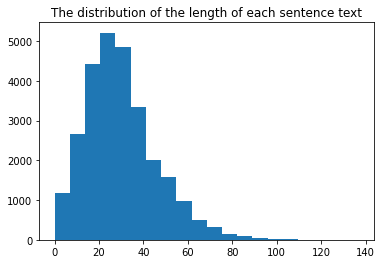

In [14]:
# get the distribution of the length of sequence in each sentence text
import matplotlib.pyplot as plt

plt.title("The distribution of the length of each sentence text")
plt.hist(seq_length, bins=20)
plt.xticks(np.arange(0, 150, 20))
plt.show()

In [15]:
# pad sequence (get the first 80 text sequence)
sequence_length = 137
x_train= sequence.pad_sequences(x_train_seq, dtype='float32', truncating='post', padding='post')
x_train= x_train[:, :sequence_length]

print(x_train)
print(x_train.shape)

[[ 737.    2.    3. ...    0.    0.    0.]
 [   4.    8.   27. ...    0.    0.    0.]
 [  68.   12.  328. ...    0.    0.    0.]
 ...
 [1145.  712.  594. ...    0.    0.    0.]
 [ 645.    0.    0. ...    0.    0.    0.]
 [   3.  191.    4. ...    0.    0.    0.]]
(27393, 137)


### processing numbers ###

In [16]:
# the counts of the numbers in each sentence, get the distribution

max_number_seq = 0
num_seq_length = list()
for i in numbers:
    num_seq_length.append(len(i))
max_number_seq = max(num_seq_length)
print("max number sequence length: ", max_number_seq)


max number sequence length:  22


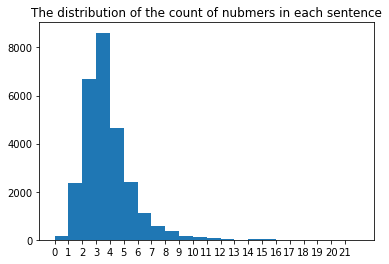

In [17]:
# get the distribution of the count of the nubmers
import matplotlib.pyplot as plt

plt.title("The distribution of the count of nubmers in each sentence")
plt.hist(num_seq_length, bins=max_number_seq)
plt.xticks(np.arange(max_number_seq))
plt.show()

In [18]:
# pad sequence (get the first 5 nubmers)
max_number_seq = 5
x_train_num = sequence.pad_sequences(numbers, dtype='float32', truncating='post', padding='post')
x_train_num = x_train_num[:, :max_number_seq]

print(x_train_num)
print(x_train_num.shape)

[[6.66666e-01 9.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.20000e+02 5.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.00000e+01 2.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 ...
 [2.00000e+00 1.00000e+00 2.30000e+01 0.00000e+00 0.00000e+00]
 [8.51840e+04 3.52000e+02 0.00000e+00 0.00000e+00 0.00000e+00]
 [7.51000e+00 8.22000e+00 7.86000e+00 8.36000e+00 8.09000e+00]]
(27393, 5)


### processing answers ###

In [19]:

# # build a word vocab that contains top  most frequent words
# tok = Tokenizer()
# tok.fit_on_texts(answers)

# print("token vocab length:", len(tok.word_index))
# # print(tok.word_index)

# y_train_seq = tok.texts_to_sequences(answers)
# max_seq = 0
# for i in y_train_seq:
#     if len(i) > max_seq:
#         max_seq = len(i)
# print("max sequence length: ", max_seq)

# y_train = sequence.pad_sequences(y_train_seq, padding='post')

# print(y_train)
# print(y_train.shape)

In [20]:
y_train = answers

for i in range(len(y_train)):
    a = y_train.iloc[i]
    if a == 999999999999999:
        print(i, a)
    

648 999999999999999.0
705 999999999999999.0
1580 999999999999999.0
2534 999999999999999.0
3027 999999999999999.0
3643 999999999999999.0
4232 999999999999999.0
4523 999999999999999.0
4688 999999999999999.0
5406 999999999999999.0
5453 999999999999999.0
5475 999999999999999.0
5479 999999999999999.0
5979 999999999999999.0
6101 999999999999999.0
6179 999999999999999.0
6795 999999999999999.0
7098 999999999999999.0
7997 999999999999999.0
7998 999999999999999.0
8708 999999999999999.0
9258 999999999999999.0
9560 999999999999999.0
9697 999999999999999.0
10297 999999999999999.0
10510 999999999999999.0
10680 999999999999999.0
10764 999999999999999.0
10782 999999999999999.0
11058 999999999999999.0
11231 999999999999999.0
11335 999999999999999.0
12311 999999999999999.0
14551 999999999999999.0
14580 999999999999999.0
14669 999999999999999.0
14949 999999999999999.0
15192 999999999999999.0
15300 999999999999999.0
15596 999999999999999.0
15875 999999999999999.0
16216 999999999999999.0
16220 999999999999

In [21]:
print(train_problems[319])
print(answers[319])
print(y_train[319])

if n 8 9 8 what is the units digit of n ?
0.0
0.0


In [22]:
# Load Glove vectors

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, errors='ignore') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 300
glove_vec_file = 'dataset/glove.6B.300d.txt'
embedding_matrix = create_embedding_matrix(glove_vec_file, tok.word_index, embedding_dim)

In [23]:
vocab_size = len(tok.word_index) + 1
print(vocab_size)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)

8528
7484
0.8775797373358349


### building model ###

In [24]:
LSTM_DIM = 32
DROPOUT = 0.1
ACTIVATION = 'relu'
OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'
HIDDEN_DIM = 16

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, Input
from keras.layers.merge import concatenate

def buildModel(vsize, input_dim, maxlen, emb_matrix, maxnumbers):

    text_input = Input(shape=(maxlen, ))     
    numerical_input = Input(shape=(maxnumbers, ))
    
    emb = Embedding(input_dim=vsize, 
                   output_dim=input_dim, 
                   weights=[emb_matrix],
                   trainable=False)(text_input)
    
    z = LSTM(LSTM_DIM)(emb)
    z = Dropout(DROPOUT)(z)
    z = Dense(HIDDEN_DIM, activation=ACTIVATION)(z)
    
    numerical_input = Input(shape=(maxnumbers, ))
    
    merged = concatenate([z, numerical_input])    
    predictions = Dense(1, activation='linear')(merged)
    
    model = Model([text_input, numerical_input], outputs=predictions)
    
    model.compile(optimizer=OPTIMIZER,
                  loss = LOSS,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

model = buildModel(vocab_size, embedding_dim, sequence_length, embedding_matrix, max_number_seq)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 137)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 137, 300)     2558400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           42624       embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [25]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers

# inputs = tf.keras.Input(shape=(sequence_length,), dtype="int64")

# # input_dim: the size of vocabulary
# # input_length: Length of input sequences
# # output_dim: dimension of the dense embedding

# x = layers.Embedding(
#     input_dim=max_features, 
#     output_dim=embedding_dim,
#     input_length=sequence_length, 
# )(inputs)

# x = layers.LSTM(units=150, activation='relu',)(x)

# x = layers.Dropout(0.1)(x)
# x = layers.Dense(units=150, activation='relu')(x)

# x = layers.Concatenate(axis=1)([x, x_train_num])
# x = layers.Dense(units=171, activation='linear')(x)
# # len(x_train) + len(x_train_num) = 150 + 21 = 171

# predictions = layers.Dense(9, activation='linear')(x)

# model = tf.keras.Model(inputs, predictions)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# print(model.summary())

In [26]:
print(x_train.shape)
print(x_train_num.shape)
print(y_train.shape)


(27393, 137)
(27393, 5)
(27393,)


In [27]:
EPOCHS = 1

model.fit(
    x=[x_train, x_train_num],
    y=y_train,
    batch_size=50,
    validation_split=0.1,
    epochs=EPOCHS,
)

494/494 [==============================] - 33s 64ms/step - loss: nan - rmse: nan - val_loss: nan - val_rmse: nan


In [28]:
# model.evaluate(test_ds)